## Python深度学习基于PyTorch

### 入门例子(手写例子)

In [1]:
from jupyterthemes import jtplot
jtplot.style("gruvboxl")

import numpy as np

# 导入torch
import torch

# 导入mnist数据集
from torchvision.datasets import mnist

# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 导入优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [2]:
# 定义超参数
train_batch_size = 60
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [3]:
# 定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# 下载数据，并对数据进行预处理
train_dataset = mnist.MNIST("./dataset", train=True, transform=transform, download=True)
test_dataset = mnist.MNIST("./dataset", train=False, transform=transform)

# dataloader是一个可迭代对象，可以像迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

### 数据可视化

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

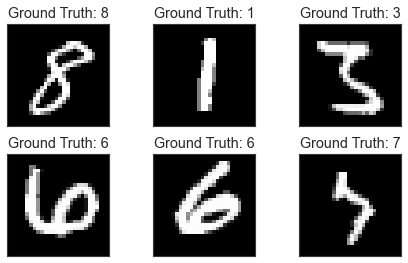

In [5]:
# 可视化
example = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(example)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(example_target[i]))
    plt.xticks([])
    plt.yticks([])

In [6]:
# 定义网络
class Net(nn.Module):
    """
    使用sequential构建网络
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer_1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer_2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer_3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)

        return x

In [7]:
# 检查设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 实例化网络
model = Net(28*28, 300, 100, 10)
model.to(device)

# 定义损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
# 训练模型
losses = []
acces = []
eval_losses = []
eval_aces = []

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改学习率
    if epoch % 5 == 0:
        optimizer.param_groups[0]["lr"] *= 0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)

        # 前向传播
        out = model(img)
        loss = criterion(out, label)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录误差
        train_loss += loss.item()

        # 计算分类准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))

    # 测试集效果检验
    eval_loss = 0
    eval_acc = 0

    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)

        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_aces.append(eval_acc / len(test_loader))
    print("epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
           epoch, train_loss/ len(train_loader), train_acc / len(train_loader), eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 0.9708, Train Acc: 0.7928, Test Loss: 0.5151, Test Acc: 0.9004
epoch: 1, Train Loss: 0.4583, Train Acc: 0.9001, Test Loss: 0.3353, Test Acc: 0.9276
epoch: 2, Train Loss: 0.3354, Train Acc: 0.9207, Test Loss: 0.2618, Test Acc: 0.9406
epoch: 3, Train Loss: 0.2736, Train Acc: 0.9334, Test Loss: 0.2188, Test Acc: 0.9470
epoch: 4, Train Loss: 0.2340, Train Acc: 0.9419, Test Loss: 0.1880, Test Acc: 0.9522
epoch: 5, Train Loss: 0.2142, Train Acc: 0.9470, Test Loss: 0.1862, Test Acc: 0.9544
epoch: 6, Train Loss: 0.2099, Train Acc: 0.9476, Test Loss: 0.1850, Test Acc: 0.9546
epoch: 7, Train Loss: 0.2079, Train Acc: 0.9486, Test Loss: 0.1833, Test Acc: 0.9560
epoch: 8, Train Loss: 0.2045, Train Acc: 0.9496, Test Loss: 0.1780, Test Acc: 0.9564
epoch: 9, Train Loss: 0.2030, Train Acc: 0.9493, Test Loss: 0.1805, Test Acc: 0.9548
epoch: 10, Train Loss: 0.2010, Train Acc: 0.9504, Test Loss: 0.1761, Test Acc: 0.9562
epoch: 11, Train Loss: 0.1999, Train Acc: 0.9498, Test Loss: 0.1

### 可视化训练过程

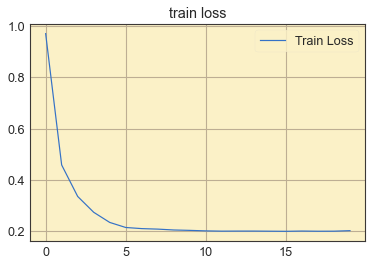

In [9]:
plt.title("train loss")
plt.plot(np.arange(len(losses)), losses)
plt.legend(["Train Loss"], loc="upper right")
